In [1]:
import tensorflow as tf
import numpy as np

We want to convert our model to '.pb' format so that we can convert it to onnx using tf2onnx.convert(), therefore we first load our '.keras' model and convert it to '.pb' format

In [2]:
model = tf.keras.models.load_model('./pose_classification_model/pose_classification_13:14:15_18831.keras')

2024-04-18 11:05:49.202265: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-18 11:05:49.202290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-18 11:05:49.202297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-18 11:05:49.202316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 11:05:49.202329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/aditya/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 496 variables

In [3]:
# We're saving the '.keras' model in '.pb' format, so that we can convert '.pb' format to '.onnx' using tf2onnx
tf.saved_model.save(model, './pose_classification_model_pb')

INFO:tensorflow:Assets written to: ./pose_classification_model_pb/assets


INFO:tensorflow:Assets written to: ./pose_classification_model_pb/assets


Let's check whether the '.pb' model was correctly saved or not by performing an inference on it

In [4]:
loaded_model = tf.saved_model.load('./pose_classification_model_pb')

In [5]:
# Access the model's signature
signature_keys = list(loaded_model.signatures.keys())
print("Signature keys:", signature_keys)

Signature keys: ['serving_default']


In [6]:
# Get the inference function from the model's signature
inference_func = loaded_model.signatures[signature_keys[0]]

In [7]:
test_data = np.load('005349821.npy')
test_data = test_data.reshape(1, test_data.shape[0], test_data.shape[1], test_data.shape[2])
test_data = tf.constant(test_data)
test_data.shape

TensorShape([1, 480, 640, 4])

In [8]:
output = inference_func(test_data)
output = tf.reshape(output['output_0'], (output['output_0'].shape[1]))
tf.argmax(output) # output class=2 which is home-activities, thus models was saved correctly in '.pb' format

2024-04-18 11:06:26.375176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(), dtype=int64, numpy=2>

Converting the 'pb' model to 'onnx' format

In [9]:
! python -m tf2onnx.convert --saved-model ./pose_classification_model_pb/ --output ./pose_classification_model/pose_classification_13:14:15_18831.onnx

/opt/miniconda3/envs/aditya/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-04-18 11:06:54,946 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2024-04-18 11:06:54,948 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-04-18 11:07:00,833 - INFO - Signatures found in model: [serving_default].
2024-04-18 11:07:00,833 - WARNING - '--signature_def' not specified, using first signature: serving_default
2024-04-18 11:07:00,834 - INFO - Output names: ['output_0']
2024-04-18 11:07:05,789 - INFO - Using tensorflow=2.16.1, onnx=1.13.0, tf2onnx=1.16.1/15c810
2024-04-18 11:07:05,789 - INFO - Using opset <onnx, 15>
2024-04-18 11:07:05,979 - INFO - Computed 0 values for constan

In [2]:
import onnx, onnxruntime
import torch

from onnx2pytorch import ConvertModel
from torch.nn.utils import prune

In [3]:
## Now let's load the corresponding onnx model and convert it to corresponding pytorch version
pose_classification_onnx_model = onnx.load('./pose_classification_model/pose_classification_13:14:15_18831.onnx')

Converting the 'onnx' model to 'torch' model

In [4]:
pose_classification_pytorch_model = ConvertModel(pose_classification_onnx_model)

/opt/miniconda3/envs/aditya/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


In [13]:
torch.save(pose_classification_pytorch_model, './pose_classification_model/pose_classificaiton_model_torch_0.pth')

## Evaluate baseline performance of the converted torch model

In [5]:
import os

In [6]:
dataset_path = '../data/processed/'

x_train_suffix = 'train_4_channel_info'
y_train_suffix = 'train_labels_pose_class'

x_val_suffix = 'val_4_channel_info'
y_val_suffix = 'val_labels_pose_class'
dataset_path, x_train_suffix, y_train_suffix, x_val_suffix, y_val_suffix

('../data/processed/',
 'train_4_channel_info',
 'train_labels_pose_class',
 'val_4_channel_info',
 'val_labels_pose_class')

In [7]:
x_train = os.listdir(f'{dataset_path}/{x_train_suffix}')
y_train = os.listdir(f'{dataset_path}/{y_train_suffix}')
x_train.sort(), y_train.sort() # so that they matchup i.e x_train[0] labels y_train[0]

(None, None)

In [8]:
x_val = os.listdir(f'{dataset_path}/{x_val_suffix}')
y_val = os.listdir(f'{dataset_path}/{y_val_suffix}')
x_val.sort(), y_val.sort()

(None, None)

In [9]:
from utilities.data_loader import data_loader

In [10]:
train_dataset, val_dataset = data_loader(dataset_path, x_train, y_train, x_val, y_val, x_train_suffix, y_train_suffix, x_val_suffix, y_val_suffix)

[+] Train=> len_X: 2528 len_Y: 2528
[+] Val=> len_X: 1094 len_Y: 1094


2024-04-19 18:09:41.784344: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-19 18:09:41.784370: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-19 18:09:41.784377: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-19 18:09:41.784396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 18:09:41.784409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
total_batches_val = len(list(val_dataset))
print(f"[+] Total Batches in validation dataset {total_batches_val}")

2024-04-19 18:09:50.014101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[+] Total Batches in validation dataset 69


Since we converted an onnx model to torch model thus we used ConvertModel() method for this. And ConvertModel() does not support batch sizes > 1.<br>
Thus we convert the 32 batches to 1 batch input, also val_dataset has tensorflow tensors and we need to convert them to torch.tensor in the loop, these are the reasons why validation process is a little slow

In [12]:
pose_classification_pytorch_model.to('mps')

ConvertModel(
  (Transpose_StatefulPartitionedCall/functional_1_1/conv2d_1/convolution__6:0): Transpose()
  (Conv_Conv__682:0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv_Conv__684:0): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/rescaling_1/mul:0): mul()
  (Sub_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/Sub:0): mul()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/truediv:0): mul()
  (Conv_Conv__692:0): Sequential(
    (0): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  )
  (Sigmoid_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/Sigmoid:0): Sigmoid()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/mul_1:0): mul()
  (Conv_Conv__698:0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [13]:
def validate_model(model, val_dataset, total):
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    
    batch_count = 0
    with torch.no_grad(): 
        for batch in val_dataset:
            inputs = (torch.from_numpy(batch[0].numpy())).to('mps') # This is done because val_dataset has tensorflow tensors, so we need to convert them to torch tensors
            labels = (torch.from_numpy(batch[1].numpy())).to('mps') # Move the tensors to 'mps' to use Mac GPU

            for i in range(len(labels)):
                feed_input = (inputs[i]).view(1, inputs.shape[1], inputs.shape[2], inputs.shape[3])
                feed_label = (labels[i]).view(1,).int()
                
                output = model(feed_input)
                predicted_class = torch.argmax(output)
                
                if predicted_class == feed_label[0]:
                    correct += 1
                total += 1
            batch_count += 1
            print(f"[+] Validation Batch No: {batch_count} done. Percent Completion: {(batch_count / total_batches_val) * 100}")
    return (correct / total) * 100

In [14]:
def return_y_preds_y_true(model, val_dataset):
    correct = 0
    total = 0
    y_true, y_pred = [], []

    batch_count = 0
    with torch.no_grad(): 
        for batch in val_dataset:
            inputs = (torch.from_numpy(batch[0].numpy())).to('mps') # This is done because val_dataset has tensorflow tensors, so we need to convert them to torch tensors
            labels = (torch.from_numpy(batch[1].numpy())).to('mps') # Move the tensors to 'mps' to use Mac GPU

            for i in range(len(labels)):
                feed_input = (inputs[i]).view(1, inputs.shape[1], inputs.shape[2], inputs.shape[3])
                feed_label = (labels[i]).view(1,).int()
                
                output = model(feed_input)
                predicted_class = torch.argmax(output)
                
                y_true.append(int(feed_label[0]))
                y_pred.append(int(predicted_class))

                if predicted_class == feed_label[0]:
                    correct += 1
                total += 1
            batch_count += 1
            print(f"[+] Validation Batch No: {batch_count} done. Percent Completion: {(batch_count / total_batches_val) * 100}")
    return [y_true, y_pred, (correct / total) * 100]

In [15]:
accuracy = validate_model(pose_classification_pytorch_model, val_dataset, total_batches_val)

[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-19 18:12:13.783412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
print(f"[+] Accuracy of baseline model: {accuracy}")

[+] Accuracy of baseline model: 61.24314442413162


In [17]:
y_true, y_pred, accuracy = return_y_preds_y_true(pose_classification_pytorch_model, val_dataset)

[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-19 18:14:53.931530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
from utilities.utils import make_confusion_matrix

In [19]:
class_names = {
 'sports',
 'miscellaneous',
 'home activities',
 'occupation',
 'fishing and hunting',
 'home repair',
 'conditioning exercise',
 'lawn and garden',
 'religious activities',
 'music playing',
 'inactivity quiet/light',
 'water activities',
 'running',
 'winter activities',
 'walking',
 'dancing',
 'bicycling',
 'transportation',
 'self care',
 'volunteer activities'
}

<h5>Examining the confusion matrix of the original model</h5>

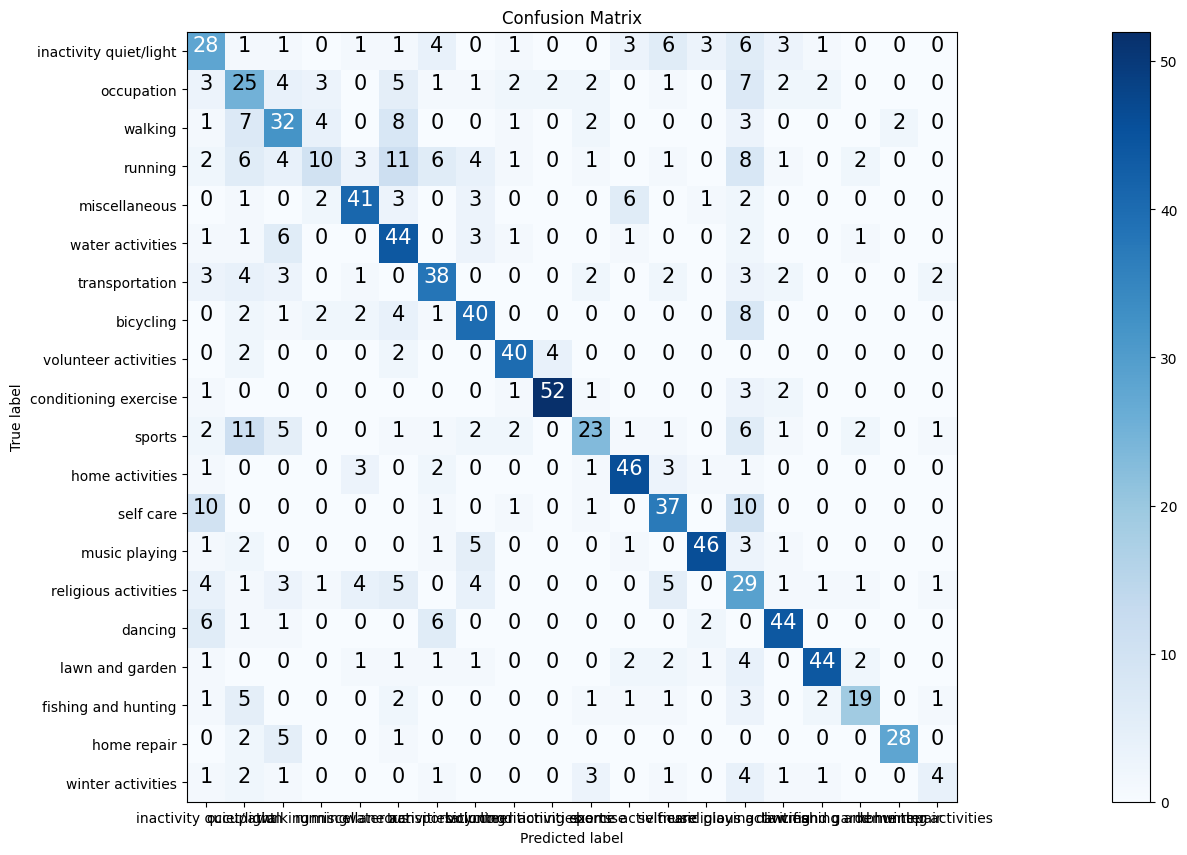

In [25]:
make_confusion_matrix(y_true, y_pred, class_names, (40, 10))

## Unstructured Pruning

We will implement a type of pruning-aware training, i.e, we will fine-tune the pruned model to recover the losses in accuracy due to pruning while maintaing almost similar pruning percentage.

In [4]:
from torch.nn.utils import prune

In [14]:
# Let's print the model to see the input and output shapes of each layer, this will help to decide the pruning ratios, for layers with more inputs or outputs
# we will keep pruning ratio higher, and we will also increase the pruning for the conv layers at the end of the model
# Like (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2)) means this convolutional layer has 16 feature maps as i/p and 64 feature maps as o/p
pose_classification_pytorch_model

ConvertModel(
  (Transpose_StatefulPartitionedCall/functional_1_1/conv2d_1/convolution__6:0): Transpose()
  (Conv_Conv__682:0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv_Conv__684:0): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/rescaling_1/mul:0): mul()
  (Sub_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/Sub:0): mul()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/truediv:0): mul()
  (Conv_Conv__692:0): Sequential(
    (0): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  )
  (Sigmoid_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/Sigmoid:0): Sigmoid()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/mul_1:0): mul()
  (Conv_Conv__698:0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [3]:
from utilities.utils import find_unstructured_prune_ratio

Below code is used to see what types of convolutional layers are present and the number of parameters in them, so that we can set the pruning ratio accordingly

In [16]:
for element in pose_classification_pytorch_model.named_parameters():
    if ('Conv_Conv' in element[0]) and ('weight' in element[0]):
        layer_num = None
        if (element[0][14] >= '0' and element[0][14] <= '9'):
            layer_num = int(element[0][11:15])
        else:
            layer_num = int(element[0][11:14])
        # print(element[0], layer_num)

        # Calculate the number of parmaters in the current convolutional layer
        inputs, outputs = element[1].shape[1], element[1].shape[0]
        kernel_w, kernel_h = element[1].shape[2], element[1].shape[3]
        num_params = (kernel_h * kernel_w * inputs + 1) * outputs

        print("[+] ", element[0], " num_params: ", num_params)
        # Check the layer type

[+]  Conv_Conv__682:0.weight  num_params:  148
[+]  Conv_Conv__684:0.weight  num_params:  111
[+]  Conv_Conv__692:0.1.weight  num_params:  896
[+]  Conv_Conv__698:0.weight  num_params:  4624
[+]  Conv_Conv__704:0.1.weight  num_params:  9280
[+]  Conv_Conv__710:0.weight  num_params:  2080
[+]  Conv_Conv__716:0.weight  num_params:  36992
[+]  Conv_Conv__722:0.weight  num_params:  4128
[+]  Conv_Conv__724:0.1.weight  num_params:  36992
[+]  Conv_Conv__730:0.weight  num_params:  6192
[+]  Conv_Conv__736:0.weight  num_params:  83136
[+]  Conv_Conv__742:0.weight  num_params:  9264
[+]  Conv_Conv__744:0.weight  num_params:  9408
[+]  Conv_Conv__760:0.weight  num_params:  2316
[+]  Conv_Conv__766:0.weight  num_params:  2496
[+]  Conv_Conv__768:0.weight  num_params:  18528
[+]  Conv_Conv__774:0.weight  num_params:  37248
[+]  Conv_Conv__790:0.weight  num_params:  9240
[+]  Conv_Conv__796:0.weight  num_params:  9600
[+]  Conv_Conv__798:0.weight  num_params:  36960
[+]  Conv_Conv__804:0.weight  n

In [17]:
prune_ratio_dict = {
    '800': [0.15, 0.20, 0.20, 0.25, 0.25, 0.40, 0.40], # prune ratios for convolutional layers in range 800 to 900(exclusive)
    '900': [0.15, 0.15, 0.20, 0.20, 0.30, 0.40, 0.40],
    '1000': [0.15, 0.25, 0.25, 0.30, 0.40, 0.40, 0.50],
    '1100': [0.20, 0.25, 0.25, 0.30, 0.40, 0.40, 0.50],
    '1200': [0.20, 0.25, 0.25, 0.30, 0.50, 0.55, 0.60]
}

In [18]:
for name, module in pose_classification_pytorch_model.named_modules():
    if 'Conv_Conv' in name:
        # print((list(module.named_parameters())[0])[1].shape)
        layer_num = None
        if (name[14] >= '0' and name[14] <= '9'):
            layer_num = int(name[11:15])
        else:
            layer_num = int(name[11:14])
        
        if layer_num < 800: # layers that have layer_num < 800 are ignored
            continue
        weight_matrix_shape = (list(module.named_parameters())[0][1]).shape
        
        num_params = module.weight.numel() # basically mutiplies the shape tensor to get the number of params in the current layer
        
        if layer_num >= 800 and layer_num < 900:
            if num_params < 15000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][0])
            elif num_params >= 15000 and num_params < 40000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][1])
            elif num_params >= 40000 and num_params < 70000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][2])
            elif num_params >= 70000 and num_params < 100000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][3])
            elif num_params >= 100000 and num_params < 150000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][4])
            elif num_params >= 150000 and num_params < 200000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][5])
            else:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['800'][6])
        elif layer_num >= 900 and layer_num < 1000:
            if num_params < 15000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][0])
            elif num_params >= 15000 and num_params < 40000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][1])
            elif num_params >= 40000 and num_params < 70000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][2])
            elif num_params >= 70000 and num_params < 100000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][3])
            elif num_params >= 100000 and num_params < 150000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][4])
            elif num_params >= 150000 and num_params < 200000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][5])
            else:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['900'][6])
        elif layer_num >= 1000 and layer_num < 1100:
            if num_params < 15000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][0])
            elif num_params >= 15000 and num_params < 40000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][1])
            elif num_params >= 40000 and num_params < 70000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][2])
            elif num_params >= 70000 and num_params < 100000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][3])
            elif num_params >= 100000 and num_params < 150000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][4])
            elif num_params >= 150000 and num_params < 200000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][5])
            else:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1000'][6])
        elif layer_num >= 1100 and layer_num < 1200:
            if num_params < 15000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][0])
            elif num_params >= 15000 and num_params < 40000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][1])
            elif num_params >= 40000 and num_params < 70000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][2])
            elif num_params >= 70000 and num_params < 100000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][3])
            elif num_params >= 100000 and num_params < 150000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][4])
            elif num_params >= 150000 and num_params < 200000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][5])
            else:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1100'][6])
        else:
            if num_params < 15000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][0])
            elif num_params >= 15000 and num_params < 40000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][1])
            elif num_params >= 40000 and num_params < 70000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][2])
            elif num_params >= 70000 and num_params < 100000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][3])
            elif num_params >= 100000 and num_params < 150000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][4])
            elif num_params >= 150000 and num_params < 200000:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][5])
            else:
                prune.l1_unstructured(module, name='weight', amount=prune_ratio_dict['1200'][6])
print("[+] Pruning completed")

[+] Pruning completed


In [19]:
total_params, pruned_params, prune_ratio = find_unstructured_prune_ratio(pose_classification_pytorch_model)
print("[+] Total Params: ", total_params, " number of weights pruned: ", pruned_params, " percent pruned: ", prune_ratio * 100)

[+] Total Params:  5784828  number of weights pruned:  2185495  percent pruned:  37.779774956143896


## Evaluate the performance of the pruned model

In [33]:
accuracy = validate_model(pose_classification_pytorch_model, val_dataset, total_batches_val)

[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-18 11:19:52.946674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
print(f"[+] Accuracy of pruned model: {accuracy}")

[+] Accuracy of pruned model: 50.36563071297989


We can that due to pruning the accuracy has dropped from 61.24% to 50.36%. Now we'll fine-tune the pruned-model(pruning aware training) for small number of epochs=2, to recover the lost accuracy.

## Fine tune the pruned model to recover the accuracy

In [2]:
import torch.optim as optim

In [21]:
total_batches_train = len(list(train_dataset))
print(f"[+] Total Batches in train dataset {total_batches_train}")

2024-04-18 11:42:04.737478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 2486 of 2528
2024-04-18 11:42:04.975499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-18 11:42:17.623993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[+] Total Batches in train dataset 158


In [22]:
print(f"[+] Total Batches in train dataset {total_batches_train}")

[+] Total Batches in train dataset 158


In [11]:
# from utilities.data_loader_torch import CustomPyTorchDataset

Below we have used Adam optimizer with a very small learninig rate, lr=1e-5 since we want our pruned model to smoothly adjust its params, this done so that the weights that were zeroed out due to pruning remain zero and we can smoothly recover the accuracy.

In [24]:
def train_model(model, train_dataset, val_dataset, total_batches_train, total_batches_val, epochs=4, lr=1e-5, threshold=0.3):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        batch_count_train = 0

        for batch in train_dataset:
            inputs = (torch.from_numpy(batch[0].numpy())).to('mps')
            labels = (torch.from_numpy(batch[1].numpy())).to('mps')
            
            optimizer.zero_grad() # to zero out the gradients after each batch is processed
            batch_loss = 0.0
            
            for i in range(len(labels)):
                feed_input = inputs[i].unsqueeze(0)  
                feed_label = labels[i].unsqueeze(0).long()

                output = model(feed_input)
                
                loss = criterion(output, feed_label)
                batch_loss += loss

            batch_count_train = batch_count_train + 1
            # Backpropagation and parameter update after processing the whole batch
            batch_loss.backward()
            optimizer.step()
            
            running_loss += batch_loss.item() / len(labels)  # Average loss per sample
            print(f"[+] Training Batch No: {batch_count_train}. Percent completion {(batch_count_train / total_batches_train) * 100}")
        print(f"[+] Epoch: {epoch+1}, Loss: {running_loss / total_batches_train}")

        total_params, pruned_params, prune_ratio = find_unstructured_prune_ratio(pose_classification_pytorch_model)
        print("[+] Currently total Params: ", total_params, " number of weights pruned: ", pruned_params, " percent pruned: ", prune_ratio * 100)
        
        if prune_ratio < threshold:
            print("[+] Pruning threshold limit reached. Exiting")
            break
        if (epoch % 2 == 0):
            val_accuracy = validate_model(pose_classification_pytorch_model, val_dataset, total_batches_val)
            print(f"[+] Epoch: {epoch + 1}, val-accuracy: {val_accuracy}")

In [25]:
train_model(pose_classification_pytorch_model, train_dataset, val_dataset, total_batches_train, total_batches_val, 2)

[+] Training Batch No: 1. Percent completion 0.6329113924050633
[+] Training Batch No: 2. Percent completion 1.2658227848101267
[+] Training Batch No: 3. Percent completion 1.89873417721519
[+] Training Batch No: 4. Percent completion 2.5316455696202533
[+] Training Batch No: 5. Percent completion 3.1645569620253164
[+] Training Batch No: 6. Percent completion 3.79746835443038
[+] Training Batch No: 7. Percent completion 4.430379746835443
[+] Training Batch No: 8. Percent completion 5.063291139240507
[+] Training Batch No: 9. Percent completion 5.69620253164557
[+] Training Batch No: 10. Percent completion 6.329113924050633
[+] Training Batch No: 11. Percent completion 6.962025316455696
[+] Training Batch No: 12. Percent completion 7.59493670886076
[+] Training Batch No: 13. Percent completion 8.227848101265822
[+] Training Batch No: 14. Percent completion 8.860759493670885
[+] Training Batch No: 15. Percent completion 9.49367088607595
[+] Training Batch No: 16. Percent completion 10.1

2024-04-18 11:58:22.552703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[+] Currently total Params:  5784828  number of weights pruned:  2185495  percent pruned:  37.779774956143896
[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13

2024-04-18 12:01:22.123645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-18 12:01:32.147252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 1899 of 2528
2024-04-18 12:01:35.615330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


[+] Training Batch No: 1. Percent completion 0.6329113924050633
[+] Training Batch No: 2. Percent completion 1.2658227848101267
[+] Training Batch No: 3. Percent completion 1.89873417721519
[+] Training Batch No: 4. Percent completion 2.5316455696202533
[+] Training Batch No: 5. Percent completion 3.1645569620253164
[+] Training Batch No: 6. Percent completion 3.79746835443038
[+] Training Batch No: 7. Percent completion 4.430379746835443
[+] Training Batch No: 8. Percent completion 5.063291139240507
[+] Training Batch No: 9. Percent completion 5.69620253164557
[+] Training Batch No: 10. Percent completion 6.329113924050633
[+] Training Batch No: 11. Percent completion 6.962025316455696
[+] Training Batch No: 12. Percent completion 7.59493670886076
[+] Training Batch No: 13. Percent completion 8.227848101265822
[+] Training Batch No: 14. Percent completion 8.860759493670885
[+] Training Batch No: 15. Percent completion 9.49367088607595
[+] Training Batch No: 16. Percent completion 10.1

2024-04-18 12:18:14.631135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
accuracy = validate_model(pose_classification_pytorch_model, val_dataset, total_batches_val)

[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-18 12:21:12.985860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
print("[+] Accuracy of fine-tuned pruned model: ", accuracy)

[+] Accuracy of fine-tuned pruned model:  61.608775137111515


In [29]:
torch.save(pose_classification_pytorch_model, './pruned_models/pruned_pose_classificaiton_model_0.pth')

In [44]:
pose_model = torch.load('./pruned_models/pruned_pose_classificaiton_model_0.pth')

In [21]:
total_params, pruned_params, prune_ratio = find_unstructured_prune_ratio(pose_model)
print("[+] Total Params: ", total_params, " number of weights pruned: ", pruned_params, " percent pruned: ", prune_ratio * 100)

[+] Total Params:  5784828  number of weights pruned:  2185495  percent pruned:  37.779774956143896


Fine tuning the pruned model for 2 epochs(pruning aware training) has allowed us to recover the accuracy from 50.36% to 62.24%, and the number of pruned params is the same as before since we used a very low lr.

<h5>This is just to see if that the weight matrices actually contain 0 weights and their mask is set to 0</h5>
Basically the in pytorch even after pruning the original weights are stored as'weight_orig', instead we have a mask that shows if the weight is pruned or not. If mask=0(pruned) or we can directly use module.weight to see the pruned weights.<br>
We will just print the starting 100 pruned weights, their mask and their original value before pruning only.

In [28]:
count = 0
for name, module in pose_classification_pytorch_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) and hasattr(module, 'weight'):
        if 'Conv_Conv' in name:
            # print((list(module.named_parameters())[0])[1].shape)
            layer_num = None
            if (name[14] >= '0' and name[14] <= '9'):
                layer_num = int(name[11:15])
            else:
                layer_num = int(name[11:14])
            
            if layer_num < 800: # layers that have layer_num < 800 are ignored
                continue
            
            num_layer_params = module.weight.numel()
            num_pruned_params = (module.weight == 0).sum().item()
            weight_matrix = (list(module.named_parameters())[0][1])

            orig_weight_matrix = None
            if 'weight' in list(module.named_parameters())[0][0]:
                orig_weight_matrix = list(module.named_parameters())[0][1]
                
            else:
                orig_weight_matrix = list(module.named_parameters())[1][1]

            
            pruned_weights = (module.weight == 0)
            weight_mask = list(module.named_buffers())[0][1]
            
            for i in range((pruned_weights.shape[0])):
                for j in range((pruned_weights.shape[1])):
                    for k in range((pruned_weights.shape[2])):
                        for l in range((pruned_weights.shape[3])):
                            
                            if pruned_weights[i][j][k][l]:
                                print("[+] Pruned weight found at: ", (i, j, k, l), " val: ", module.weight[i][j][k][l])
                                print("[+] Mask: ", weight_mask[i][j][k][l])
                                print("[+] Original weight value was: ", orig_weight_matrix[i][j][k][l])
                                print()
                                count += 1
                            if count > 100:
                                break
                        if count > 100:
                                break
                    if count > 100:
                                break
                if count > 100:
                                break
            break

[+] Pruned weight found at:  (0, 2, 0, 0)  val:  tensor(0., device='mps:0', grad_fn=<SelectBackward0>)
[+] Mask:  tensor(0., device='mps:0')
[+] Original weight value was:  tensor(0.0019, device='mps:0', grad_fn=<SelectBackward0>)

[+] Pruned weight found at:  (0, 5, 0, 0)  val:  tensor(0., device='mps:0', grad_fn=<SelectBackward0>)
[+] Mask:  tensor(0., device='mps:0')
[+] Original weight value was:  tensor(0.0003, device='mps:0', grad_fn=<SelectBackward0>)

[+] Pruned weight found at:  (0, 11, 0, 0)  val:  tensor(-0., device='mps:0', grad_fn=<SelectBackward0>)
[+] Mask:  tensor(0., device='mps:0')
[+] Original weight value was:  tensor(-0.0017, device='mps:0', grad_fn=<SelectBackward0>)

[+] Pruned weight found at:  (0, 21, 0, 0)  val:  tensor(0., device='mps:0', grad_fn=<SelectBackward0>)
[+] Mask:  tensor(0., device='mps:0')
[+] Original weight value was:  tensor(0.0009, device='mps:0', grad_fn=<SelectBackward0>)

[+] Pruned weight found at:  (0, 24, 0, 0)  val:  tensor(0., device=

<h5>Now let's compress the original model and the pruned model and compare their compression ratios</h5>

In [1]:
from utilities.utils import compress_file
from utilities.utils import get_compressed_file_size

In [35]:
compress_file('./pose_classification_model/pose_classificaiton_model_torch_0.pth', './compressed_models/pose_classification_torch.gz')

File compressed successfully: ./compressed_models/pose_classification_torch.gz


In [36]:
compress_file('./pruned_models/pruned_pose_classificaiton_model_0.pth', './compressed_models/pruned_pose_classification_torch.gz')

File compressed successfully: ./compressed_models/pruned_pose_classification_torch.gz


In [52]:
original_uncompressed_size, pruned_uncompressed_size = get_compressed_file_size('./pose_classification_model/pose_classificaiton_model_torch_0.pth'), get_compressed_file_size('./pruned_models/pruned_pose_classificaiton_model_0.pth')
original_compressed_size, pruned_compressed_size = get_compressed_file_size('./compressed_models/pose_classification_torch.gz'), get_compressed_file_size('./compressed_models/pruned_pose_classification_torch.gz')
f'Orginial uncompressed: {original_uncompressed_size / 1e6} MB', f'Orginial compressed: {original_compressed_size / 1e6} MB', f'Pruned uncompressed: {pruned_uncompressed_size / 1e6} MB', f'Pruned compressed: {pruned_compressed_size / 1e6} MB'

Size of compressed file './pose_classification_model/pose_classificaiton_model_torch_0.pth': 82597522 bytes
Size of compressed file './pruned_models/pruned_pose_classificaiton_model_0.pth': 125443389 bytes
Size of compressed file './compressed_models/pose_classification_torch.gz': 69856912 bytes
Size of compressed file './compressed_models/pruned_pose_classification_torch.gz': 84404808 bytes


('Orginial uncompressed: 82.597522 MB',
 'Orginial compressed: 69.856912 MB',
 'Pruned uncompressed: 125.443389 MB',
 'Pruned compressed: 84.404808 MB')

We can that pruning has increased the size of the model because in pytorch when we prune the model it does not remove the original weights instead it adds a weight_mask where if value=0 means weight is pruned. Later in the notebook we remove the pruning metadata to reduce the file size.<br>
We have shown this below:

In [33]:
pruned_pose_model = torch.load('./pruned_models/pruned_pose_classificaiton_model_0.pth')
unpruned_pose_model = torch.load('./pose_classification_model/pose_classificaiton_model_torch_0.pth')

In [48]:
count = 0
for buffer in unpruned_pose_model.named_buffers():
    if 'weight_mask' in buffer[0]:
        print(buffer[0])
        count += 1

print("[+] Number of weight mask layers: ", count)

[+] Number of weight mask layers:  0


In [50]:
count = 0
for buffer in pruned_pose_model.named_buffers():
    if 'weight_mask' in buffer[0]:
        print(buffer[0])
        count += 1
print()
print("[+] Number of weight mask layers: ", count)

Conv_Conv__804:0.weight_mask
Conv_Conv__820:0.weight_mask
Conv_Conv__826:0.weight_mask
Conv_Conv__828:0.weight_mask
Conv_Conv__830:0.weight_mask
Conv_Conv__846:0.weight_mask
Conv_Conv__852:0.weight_mask
Conv_Conv__854:0.weight_mask
Conv_Conv__860:0.weight_mask
Conv_Conv__876:0.weight_mask
Conv_Conv__882:0.weight_mask
Conv_Conv__884:0.weight_mask
Conv_Conv__890:0.weight_mask
Conv_Conv__906:0.weight_mask
Conv_Conv__912:0.weight_mask
Conv_Conv__914:0.weight_mask
Conv_Conv__920:0.weight_mask
Conv_Conv__936:0.weight_mask
Conv_Conv__942:0.weight_mask
Conv_Conv__944:0.weight_mask
Conv_Conv__950:0.weight_mask
Conv_Conv__966:0.weight_mask
Conv_Conv__972:0.weight_mask
Conv_Conv__974:0.weight_mask
Conv_Conv__976:0.weight_mask
Conv_Conv__992:0.weight_mask
Conv_Conv__998:0.weight_mask
Conv_Conv__1000:0.weight_mask
Conv_Conv__1006:0.weight_mask
Conv_Conv__1022:0.weight_mask
Conv_Conv__1028:0.weight_mask
Conv_Conv__1030:0.weight_mask
Conv_Conv__1036:0.weight_mask
Conv_Conv__1052:0.weight_mask
Conv_Co

As you can see above that the pruned model has 57 weight mask layers containing lots of params, that's why the model size of pruned model is greater, but as we have shown above pruned models have better compression ratio than unpruned models making them ideal for downloading purposes.

In [40]:
compression_ratio_original = (original_compressed_size / original_uncompressed_size) * 100
compression_ratio_pruned = (pruned_compressed_size / pruned_uncompressed_size) * 100
print("[+] Original model compression ratio: ", compression_ratio_original, " pruned model compression ratio: ", compression_ratio_pruned)

[+] Original model compression ratio:  84.54473937224076  pruned model compression ratio:  67.28517833650046


Let's remove the pruning metadata.<br>
pruned.remove(): The pruned parameter named name remains permanently pruned, and the parameter named name+'_orig' is removed from the parameter list. Similarly, the buffer named name+'_mask' is removed from the buffers.

In [53]:
for name, module in pruned_pose_model.named_modules():
    if 'Conv_Conv' in name:
        # print((list(module.named_parameters())[0])[1].shape)
        layer_num = None
        if (name[14] >= '0' and name[14] <= '9'):
            layer_num = int(name[11:15])
        else:
            layer_num = int(name[11:14])
        
        if layer_num < 800: # layers that have layer_num < 800 are ignored
            continue
        
        prune.remove(module, 'weight')
print("[+] Pruning info removed")

[+] Pruning info removed


In [55]:
accuracy = validate_model(pruned_pose_model, val_dataset, len(list(val_dataset)))

2024-04-18 12:39:48.406734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-18 12:42:34.287574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
print("[+] Pruned model with pruning metadata removed accuracy: ", accuracy)

[+] Pruned model with pruning metadata removed accuracy:  61.608775137111515


In [61]:
total_params, pruned_params, prune_ratio = find_unstructured_prune_ratio(pruned_pose_model)
print("[+] Total Params: ", total_params, " number of weights pruned: ", pruned_params, " percent pruned: ", prune_ratio * 100)

[+] Total Params:  5784828  number of weights pruned:  2185495  percent pruned:  37.779774956143896


In [59]:
torch.save(pruned_pose_model, './pruned_models/pruned_pose_classificaiton_model_1.pth')

Now after removing the pruning metadata we compare the model sizes again

In [63]:
compress_file('./pruned_models/pruned_pose_classificaiton_model_1.pth', './compressed_models/pruned_pose_classification_torch_1.gz')

File compressed successfully: ./compressed_models/pruned_pose_classification_torch_1.gz


In [64]:
original_uncompressed_size, pruned_uncompressed_size = get_compressed_file_size('./pose_classification_model/pose_classificaiton_model_torch_0.pth'), get_compressed_file_size('./pruned_models/pruned_pose_classificaiton_model_1.pth')
original_compressed_size, pruned_compressed_size = get_compressed_file_size('./compressed_models/pose_classification_torch.gz'), get_compressed_file_size('./compressed_models/pruned_pose_classification_torch_1.gz')
f'Orginial uncompressed: {original_uncompressed_size / 1e6} MB', f'Orginial compressed: {original_compressed_size / 1e6} MB', f'Pruned uncompressed: {pruned_uncompressed_size / 1e6} MB', f'Pruned compressed: {pruned_compressed_size / 1e6} MB'

Size of compressed file './pose_classification_model/pose_classificaiton_model_torch_0.pth': 82597522 bytes
Size of compressed file './pruned_models/pruned_pose_classificaiton_model_1.pth': 82597915 bytes
Size of compressed file './compressed_models/pose_classification_torch.gz': 69856912 bytes
Size of compressed file './compressed_models/pruned_pose_classification_torch_1.gz': 63433575 bytes


('Orginial uncompressed: 82.597522 MB',
 'Orginial compressed: 69.856912 MB',
 'Pruned uncompressed: 82.597915 MB',
 'Pruned compressed: 63.433575 MB')

Now we can see that the compressed file of the pruned model is a lot less in size than the compressed file of the unpruned model

In [66]:
reduction_in_size = ((original_compressed_size - pruned_compressed_size) / original_compressed_size) * 100
print("[+] Reduction in pruned model compressed file size: ", reduction_in_size)

[+] Reduction in pruned model compressed file size:  9.194991327415103


We can see that we have achieved 10% reduction in file size with pruning

In [26]:
pruned_model = torch.load('./pruned_models/pruned_pose_classificaiton_model_1.pth')
original_model = torch.load('./pose_classification_model/pose_classificaiton_model_torch_0.pth')

In [13]:
dir_path = '../data/processed/val_4_channel_info/'
entries = os.listdir(dir_path)
random_choices = np.random.randint(low=0, high=len(entries) - 1, size=500)

<h5>Let's measure the average inference time of both models</h5>

In [15]:
import time

In [39]:
def measure_avg_inference_time_torch(model, entries, random_choices):
    start = time.time()
    for i in range(len(random_choices)):
        path = dir_path + entries[random_choices[i]]
        data = None
        try:
            data = np.load(path)
            data = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])
            tensor = (torch.tensor(data)).to('mps')
            result = model(tensor)
        except Exception as e:
            print('[-] Unable to load data')
            print(e)
    end = time.time()
    return ((end - start) / len(entries))

In [38]:
original_model.to('mps')
pruned_model.to('mps')

ConvertModel(
  (Transpose_StatefulPartitionedCall/functional_1_1/conv2d_1/convolution__6:0): Transpose()
  (Conv_Conv__682:0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv_Conv__684:0): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/rescaling_1/mul:0): OperatorWrapper()
  (Sub_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/Sub:0): OperatorWrapper()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/normalization_1/truediv:0): OperatorWrapper()
  (Conv_Conv__692:0): Sequential(
    (0): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  )
  (Sigmoid_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/Sigmoid:0): Sigmoid()
  (Mul_StatefulPartitionedCall/functional_1_1/efficientnetv2-b0_1/stem_activation_1/mul_1:0): OperatorWrapper()
  (Conv_Conv__698:0): Conv

In [40]:
avg_inference_time_orginal = measure_avg_inference_time_torch(original_model, entries, random_choices)

In [42]:
avg_inference_time_pruned = measure_avg_inference_time_torch(pruned_model, entries, random_choices)

In [44]:
print("[+] Original model avg_inference_time: ", avg_inference_time_orginal * 1e3, "ms pruned model avg_inference_time: ", avg_inference_time_pruned * 1e3, "ms")

[+] Original model avg_inference_time:  61.67400558862216 ms pruned model avg_inference_time:  60.5240548114672 ms


Looks like we didn't gain any significant gains in inference time, because we need specialised hardware to take advantage of the sparse matrix multiplication. This test was done on (480, 640, 4) shape tensors for 500 examples.

In [27]:
y_true, y_pred, accuracy = return_y_preds_y_true(pruned_model, val_dataset)

[+] Validation Batch No: 1 done. Percent Completion: 1.4492753623188406
[+] Validation Batch No: 2 done. Percent Completion: 2.898550724637681
[+] Validation Batch No: 3 done. Percent Completion: 4.3478260869565215
[+] Validation Batch No: 4 done. Percent Completion: 5.797101449275362
[+] Validation Batch No: 5 done. Percent Completion: 7.246376811594203
[+] Validation Batch No: 6 done. Percent Completion: 8.695652173913043
[+] Validation Batch No: 7 done. Percent Completion: 10.144927536231885
[+] Validation Batch No: 8 done. Percent Completion: 11.594202898550725
[+] Validation Batch No: 9 done. Percent Completion: 13.043478260869565
[+] Validation Batch No: 10 done. Percent Completion: 14.492753623188406
[+] Validation Batch No: 11 done. Percent Completion: 15.942028985507244
[+] Validation Batch No: 12 done. Percent Completion: 17.391304347826086
[+] Validation Batch No: 13 done. Percent Completion: 18.84057971014493
[+] Validation Batch No: 14 done. Percent Completion: 20.28985507

2024-04-19 18:20:16.188338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<h5>Examining the confusion matrix of the pruned model</h5>

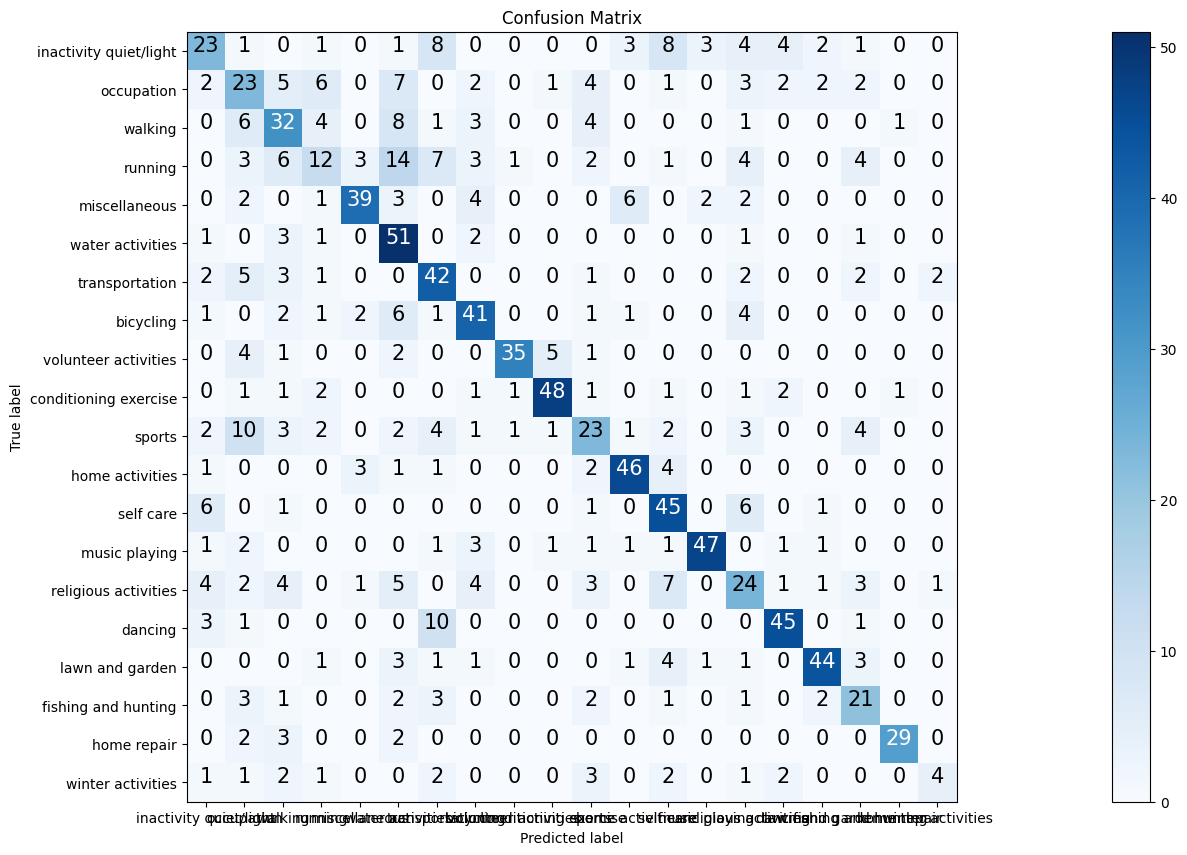

In [28]:
make_confusion_matrix(y_true, y_pred, class_names, (40, 10))